# MKCVA Nonlinear System Identification: Newell-Lee Evaporator


In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from scipy.optimize import minimize
from scipy.linalg import cholesky
import matplotlib.pyplot as plt
import statsmodels.api as sm
from time import time
import pandas as pd
import numpy as np
import kmedoids
import pickle

## Load the Data Set

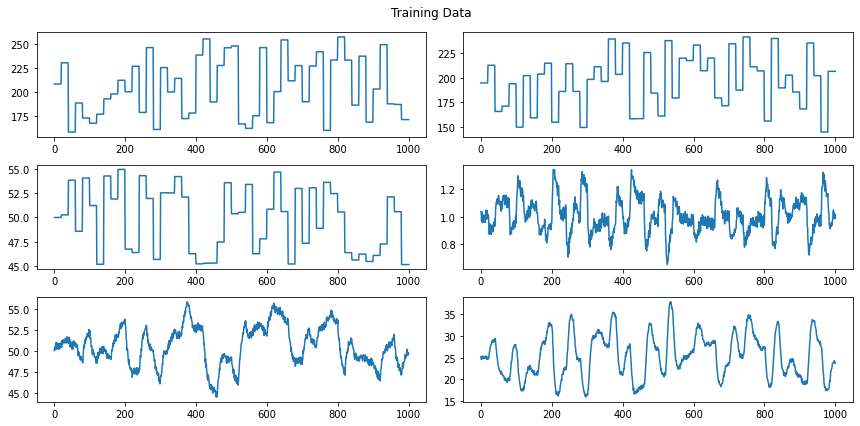

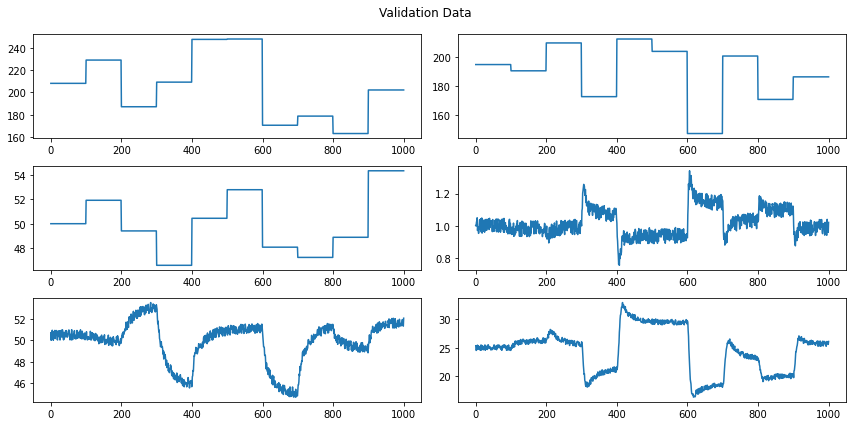

(1001, 6)
(1001, 6)


In [3]:
evap_df = pd.read_csv('evap_seed1.csv', index_col=0)
evap_df2 = pd.read_csv('evap_seed3_valid.csv', index_col=0)

v_name = ['F200', 'P100', 'F3', 'L2', 'P2', 'X2']
noise_var = np.array([0, 0, 0, 0.1, 1, 1])

np.random.seed(0)

def prepare_and_plot(evap_df, noise_var, label):
    plt.figure(figsize=(12, 6))
    timepts = np.linspace(0, 1000, 1001)
    ctr = 1
    res = list()
    for j in range(len(v_name)):
        plt.subplot(3,2,ctr)
        data = np.interp(timepts, evap_df.index.values, evap_df[v_name[j]].values)
        data += (np.random.rand(len(data))-0.5)*noise_var[j]
        res.append(data)
        plt.plot(data)
        ctr += 1

    plt.suptitle(label)
    plt.tight_layout()
    plt.show()
    
    return np.transpose(np.vstack(res))

Z_train = prepare_and_plot(evap_df, noise_var, 'Training Data')
Z_valid = prepare_and_plot(evap_df2, noise_var, 'Validation Data')
print(Z_train.shape)
print(Z_valid.shape)

## Declare KPCA and MKCVA classes

In [4]:
class KPCA:
    def kernel_func(self, x1, x2):
        # x1 size: [no. of samples x no. of features]
        # x2 size: [no. of samples x no. of features]
        
        D = np.sum((x1 / self.kw) ** 2, axis=1, keepdims=True) \
            + np.sum((x2 / self.kw).T ** 2, axis=0, keepdims=True) \
            - 2 * np.tensordot(x1 / self.kw**2, x2.T, axes=1)
        L = np.tensordot(x1, x2.T, axes=1) + 1
        return self.w * L + (1 - self.w) * np.exp(-D)
        
    def fit_transform(self, X, kw, w, n_comp=None):
        # Compute kernel matrix
        self.X = X
        self.kw = kw
        self.w = w
        self.N = len(self.X)
        
        # Calculate reduced kernel matrix with k-medoids clustering 
        dist = pairwise_distances(self.X)
        dm = kmedoids.KMedoids(method='fasterpam', 
                               n_clusters=int(0.25*self.N), 
                               random_state=0).fit(dist)
        self.X_red = X[dm.medoid_indices_, :]
        self.N_red = len(dm.medoid_indices_)
        self.medoid_indices = dm.medoid_indices_
        self.K = self.kernel_func(self.X_red, self.X_red)

        # Center the kernel matrix
        self.U = np.ones((self.N_red, self.N_red)) / self.N_red
        Kc = self.K - self.U @ self.K - self.K @ self.U + self.U @ self.K @ self.U

        # Perform eigenvalue decomposition
        eigvals, eigvecs = np.linalg.eigh(Kc / self.N_red)

        # Ensure the eigenvalues are sorted in decreasing order
        ind = (-eigvals).argsort()
        eigvals = eigvals[ind]
        eigvecs = eigvecs[:,ind]
        
        if n_comp == None:
            # Get eigenvalues using CPV = 99%
            CPV = np.cumsum(eigvals) / np.sum(eigvals)
            self.n_comp = np.argwhere(CPV > 0.99)[0][0]
        else:
            self.n_comp = n_comp
        
        self.CPV = CPV
        
        # Compute the projection matrix
        self.P = eigvecs[:,:self.n_comp] @ np.diag(eigvals[:self.n_comp] ** -0.5)
        
        # Project the training data X via the reduced centered kernel matrix (Kct)
        scores = self.transform(self.X)
        return scores
    
    def transform(self, Xt):
        if len(Xt.shape) == 1:
            Xt = Xt.reshape(1, -1)
        
        Kt = np.transpose(self.kernel_func(self.X_red, Xt))
        Ut = np.ones((Xt.shape[0], self.N_red)) / self.N_red
        Kct = Kt - Ut @ self.K - Kt @ self.U + Ut @ self.K @ self.U
        scores = Kct @ self.P
        return scores
    
class MKCVA:
    def __init__(self, verbose=None):
        if verbose == None:
            self.verbose = 0
        else:
            self.verbose = verbose
    
    def identify(self, Z_train, UI, YI, kw=None, w=None, n_states=None):
        
        start = time()
        self.UI = UI  # Column indices of input vars 
        self.YI = YI  # Column indices of output vars
        N = Z_train.shape[0]

        # Perform Standard Scaling on raw data [u y]
        sc_raw = StandardScaler()
        Z_train_sc = sc_raw.fit_transform(Z_train)
        y_train = Z_train_sc[:, YI]
        self.sc_raw = sc_raw

        # Perform KPCA on scaled [u(k), y(k-1)] data
        
        Z_kpca = np.hstack((Z_train_sc[1:, self.UI], 
                            Z_train_sc[:-1, self.YI]))
        
        kpca_uy = KPCA()
        kpca_score_uy = kpca_uy.fit_transform(Z_kpca, kw, w)
        self.kpca_uy = kpca_uy
        
        # Perform KPCA on scaled [y] data
        kpca_y = KPCA()
        kw = kpca_uy.kw * (len(YI) / Z_train.shape[1])
        kpca_score_y = kpca_y.fit_transform(Z_train_sc[:,YI], kw[YI], w)
        N_uy, N_y = kpca_uy.n_comp, kpca_y.n_comp

        # Calculate the suggested no. of lags on the KPCA scores
        _, ci = sm.tsa.acf(np.sum(kpca_score_y ** 2, axis=1), alpha=0.05)
        self.n_lags = np.argwhere(ci[:,0] < 0)[0][0]
        p = f = self.n_lags
        
        # Create Hankel matrices: Yp and Yf from KPCA scores
        Yp, Yf, Yp_all = [], [], []
        for k in np.arange(N-p-f):
            Yp.append(np.flip(kpca_score_uy[k:k+p, :].reshape(-1, 1)))

        for k in np.arange(1, N-p-f+1):
            Yf.append(kpca_score_y[k+p:k+p+f, :].reshape(-1, 1))

        Yp = np.transpose(np.hstack(Yp))
        Yf = np.transpose(np.hstack(Yf))
        Np = Yp.shape[0]

        # Standardize the Hankel matrices
        sc_p = StandardScaler()
        sc_f = StandardScaler()
        Yp_scaled = sc_p.fit_transform(Yp)
        Yf_scaled = sc_f.fit_transform(Yf)
        self.sc_p = sc_p

        # Perform CCA
        Epp = cholesky(np.dot(Yp_scaled.T, Yp_scaled))  # Past Cholesky matrix
        Eff = cholesky(np.dot(Yf_scaled.T, Yf_scaled))  # Future Cholesky matrix
        Efp = np.dot(Yf_scaled.T, Yp_scaled)            # Cross-covariance matrix
        H = np.linalg.inv(Eff.T) @ Efp @ np.linalg.inv(Epp)

        U, S, V = np.linalg.svd(H)

        # Calculate the suggested no. of states via knee of SV plot
        if n_states == None:
            n_states = np.minimum(2 + np.argmax(np.diff(np.diff(S))), 10)
        self.n_states = n_states

        if self.verbose:
            print(f'No. of KPCs on [u y]: {N_uy}')
            print(f'No. of KPCs on [y]:   {N_y}')
            print(f'No. of lags: {self.n_lags}')
            plt.figure(figsize=(12, 3))
            plt.subplot(131)
            plt.title('CPV Plot for KPCA on [u y]')
            plt.plot(np.arange(len(kpca_uy.CPV))+1, kpca_uy.CPV, 'b.--')
            plt.scatter(kpca_uy.n_comp, kpca_uy.CPV[kpca_uy.n_comp-1], c='r')
            plt.xlim([0, 30])
            plt.grid()
            plt.subplot(132)
            plt.title('CPV Plot for KPCA on [y]')
            plt.plot(np.arange(len(kpca_y.CPV))+1, kpca_y.CPV, 'b.--')
            plt.scatter(kpca_y.n_comp, kpca_y.CPV[kpca_y.n_comp-1], c='r')
            plt.xlim([0, 30])
            plt.grid()
            plt.subplot(133)
            plt.plot(np.arange(15)+1, S[:15], 'b.--')
            plt.scatter(n_states, S[n_states-1], c='r')
            plt.title('Singular Values plot')
            print(f'No. of states: {n_states}')
            plt.grid()
            plt.tight_layout()
            plt.show()

        # Calculate the state vectors, X
        Vn = np.transpose(V[:n_states, :])
        Jn = np.dot(Vn.T, np.linalg.inv(Epp.T))
        X = Jn @ Yp_scaled.T
        self.Jn = Jn
        
        # Solve for A, B, C, D, K
        M = X.shape[1]
        tk = np.transpose(kpca_score_uy[p-1:p+M-1, :])
        yk = np.transpose(y_train[p:p+M, :])

        CD = yk[:,:(M-1)] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                      tk[:,:(M-1)])))
        C = CD[:len(YI), :n_states]          # Output matrix
        D = CD[:len(YI), n_states:]          # Feedthrough matrix

        E = yk[:,:(M-1)] - C @ X[:,:(M-1)] - D @ tk[:,:(M-1)]
        ABK = X[:,1:M] @ np.linalg.pinv(np.vstack((X[:,:(M-1)], 
                                                   tk[:,:(M-1)], E)))
        A = ABK[:,:n_states]                 # State transition matrix
        B = ABK[:,n_states:(n_states+N_uy)]  # Input matrix
        K = ABK[:,(n_states+N_uy):]          # Kalman gain
        
        self.ident_time = time() - start     # Time elapsed for identification
        
        self.A, self.B, self.C, self.D, self.K = A, B, C, D, K
        self.X = X
       
    def init_sim(self, Z_test_sc):
        # Calculate initial state x(0) using CVA projection matrix
        tk = self.kpca_uy.transform(Z_test_sc)
        tk_p = np.flip(tk[:self.n_lags, :].reshape(1, -1))
        Yp_scaled = self.sc_p.transform(tk_p)
        x0 = self.Jn @ Yp_scaled.T
        t0 = tk[self.n_lags, :].reshape(-1, 1)
        return x0, t0
    
    def simulate(self, Z_test):
        start = time()
        Nt = Z_test.shape[0]
        Z_test_sc = self.sc_raw.transform(Z_test)
        x_pred = np.zeros((self.n_states, Nt - self.n_lags + 1)) 
        y_pred = np.zeros((len(self.YI), Nt - self.n_lags + 1))
        x0, t0 = self.init_sim(Z_test_sc)
        y0 = self.C @ x0 + self.D @ t0
        x_pred[:, 0] = x0.ravel()
        y_pred[:, 0] = y0.ravel()
        exit_code = 0
        
        for j in np.arange(1, y_pred.shape[1]):
            zk = np.hstack((Z_test_sc[j+self.n_lags-1, self.UI], 
                            y_pred[:, j-1]))
            tk = self.kpca_uy.transform(zk.reshape(1, -1))
            xk_1 = x_pred[:, j-1].reshape(-1, 1)
            xk = self.A @ xk_1 + self.B @ tk.T
            yk = self.C @ xk + self.D @ tk.T
            x_pred[:, j] = xk.ravel()
            y_pred[:, j] = yk.ravel()
            if (np.abs(yk) > 1e3).any():
                exit_code = -1
        
        x_pred = np.transpose(x_pred)
        y_pred = np.transpose(y_pred)
        y_pred = (y_pred * self.sc_raw.scale_[self.YI]) + \
                           self.sc_raw.mean_[self.YI]
        self.sim_time = time() - start
        
        return x_pred, y_pred, exit_code
    
    def R2_score(self, Z_test, y_pred):
        r2 = np.zeros(len(self.YI))
        for k in range(len(self.YI)):
            y_true = Z_test[self.n_lags-1:, self.YI[k]]
            r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                    / np.sum((y_true - np.mean(y_true)) ** 2)   
        return r2
    
    def display(self):
        print(f'No. of medoids: {self.kpca_uy.N_red}')
        print(f'No. of KPCs on [u y]: {self.kpca_uy.n_comp}')
        print(f'No. of lags: {self.n_lags}')
        print(f'No. of states: {self.n_states}')
        print(f'Indices of u: {self.UI}')
        print(f'Indices of y: {self.YI}')
        print('State-space matrices:')
        print(self.A)
        print(self.B)
        print(self.C)
        print(self.D)
        print(self.K)

## Make a trial run for a specific kw and w

No. of KPCs on [u y]: 7
No. of KPCs on [y]:   10
No. of lags: 15
No. of states: 5


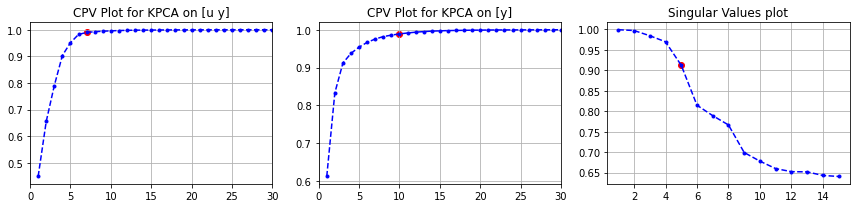

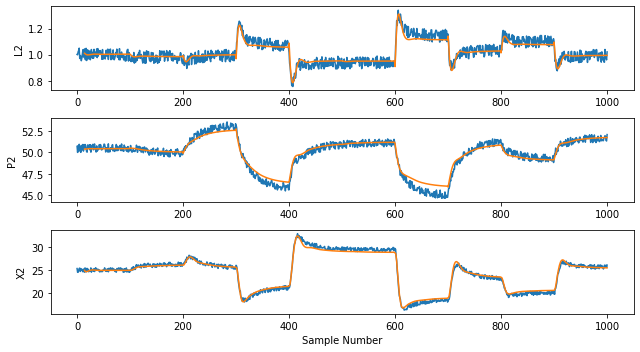

L2 fitness: 84.105%
P2 fitness: 94.270%
X2 fitness: 98.479%
Average:    92.285%
Ident time: 0.93 sec
Sim time:   0.40 sec


In [5]:
kw = np.array([3, 0.5, 3, 0.5, 3, 0.5])
w = 0.5

#kw = np.array([0.50010311, 2., 2., 0.50004548, 0.50333588, 0.50000373])
#w = 0.5002626728626437

YI, UI = np.array([3, 4, 5]), np.array([0, 1, 2])

sys = MKCVA(verbose=1)
sys.identify(Z_train, UI, YI, kw=10**kw, w=w, n_states=5)
x_pred, y_pred, exit_code = sys.simulate(Z_valid)
r2 = sys.R2_score(Z_valid, y_pred)

plt.figure(figsize=(9, 5))
var_name = ('L2', 'P2', 'X2')
for k in range(len(sys.YI)):
    plt.subplot(3, 1, k+1)
    plt.plot(Z_valid[:, sys.YI[k]])
    plt.plot(np.arange(sys.n_lags-1, Z_valid.shape[0]), y_pred[:, k])
    plt.ylabel(var_name[k])
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()

print(f"L2 fitness: {r2[0]*100:.3f}%")
print(f"P2 fitness: {r2[1]*100:.3f}%")
print(f"X2 fitness: {r2[2]*100:.3f}%")
print(f"Average:    {np.mean(r2)*100:.3f}%")
print(f"Ident time: {sys.ident_time:.2f} sec")
print(f"Sim time:   {sys.sim_time:.2f} sec")

## Hyper-parameter Optimization for MKCVA

In [6]:
YI, UI = np.array([3, 4, 5]), np.array([0, 1, 2])

# Optimize kw and w on validation data
np.random.seed(1)
X_train, y_train = list(), list()

# Upper confidence bound (UCB) acquisition func.
def obj(x, mdl, kappa):
    mean_, std_ = mdl.predict(x.reshape(1, -1), 
                              return_std=True)
    return -(mean_ + kappa*std_)

max_iter = 100
try_rand = True
for j in range(max_iter):
    
    start = time()
    if j == 0:
        kw = np.array([1, 0, 1, 0, 1, 0])
        w = 0
    
    elif j < 20 or try_rand: # Do Random Search
        kw = np.random.rand(6)
        w = np.random.rand(1)[0]
        try_rand = False
    
    else: # Do BayesOpt
        
        X = np.vstack(X_train)
        y = np.vstack(y_train)
        
        GPR = GaussianProcessRegressor(kernel=Matern(),
                                       normalize_y=False,
                                       n_restarts_optimizer=5,
                                       random_state=0).fit(X, y)
        
        # Use scipy to maximize the UCB
        bnds = [(0, 1) for _ in range(X.shape[1])]
        res = minimize(obj, X[np.argmax(y),:], bounds=bnds, method='Nelder-Mead',
                       args=(GPR, 5*(max_iter-j)/max_iter))
        
        # Save the next best point to kw and w
        kw, w = res.x[:-1], res.x[-1]
    
    elapsed_time = time() - start
    
    
    # Make a trial on the kw and w
    
    kw_trial = 10**(kw*2.5 + 0.5)  # Map kw = [0, 1] onto 10**[0.5, 3.0]
    w_trial = w*0.5 + 0.5          # Map  w = [0, 1] onto [0.5, 1.0]
    
    print(f"Iter {j}: kw: {np.array2string(kw_trial, formatter={'float': lambda x: f'{x:.2f}'})}, w: {w_trial:.2f}")
    
    sys = MKCVA(verbose=0)
    sys.identify(Z_train, UI, YI,
                 kw=kw_trial, w=w_trial)
    x_pred, y_pred, exit_code = sys.simulate(Z_valid)
    R2 = np.mean(sys.R2_score(Z_valid, y_pred))
    
    # If identification is unsuccessful (R2 < 0), do a random next trial instead
    if R2 < 0:
        try_rand = True
        print(f"    R2: Negative")
    else:
        print(f"    R2: {R2:.6f}")
        X_train.append(np.hstack((kw, w)))
        y_train.append(R2)

    print(f"    Exit code:   {exit_code}")
    print(f"    Search time: {elapsed_time:.2f} sec")
    print(f"    Ident time:  {sys.ident_time:.2f} sec")
    print(f"    Sim time:    {sys.sim_time:.2f} sec")

Iter 0: kw: [1000.00 3.16 1000.00 3.16 1000.00 3.16], w: 0.50
    R2: 0.851825
    Exit code:   0
    Search time: 0.00 sec
    Ident time:  0.25 sec
    Sim time:    0.36 sec
Iter 1: kw: [34.88 199.90 3.16 18.02 7.36 5.38], w: 0.59
    R2: 0.594317
    Exit code:   0
    Search time: 0.00 sec
    Ident time:  0.17 sec
    Sim time:    0.34 sec
Iter 2: kw: [23.12 31.04 70.31 35.32 163.32 10.26], w: 0.94
    R2: 0.582443
    Exit code:   0
    Search time: 0.00 sec
    Ident time:  0.17 sec
    Sim time:    0.37 sec
Iter 3: kw: [3.70 150.03 34.94 78.84 7.10 9.89], w: 0.90
    R2: 0.583723
    Exit code:   0
    Search time: 0.00 sec
    Ident time:  0.20 sec
    Sim time:    0.36 sec
Iter 4: kw: [833.02 19.21 170.14 490.88 545.15 5.16], w: 0.52
    R2: 0.524825
    Exit code:   0
    Search time: 0.00 sec
    Ident time:  0.20 sec
    Sim time:    0.36 sec
Iter 5: kw: [8.41 495.86 5.57 35.71 784.74 68.06], w: 0.85
    R2: 0.581896
    Exit code:   0
    Search time: 0.00 sec
    Ident t

D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 34: kw: [1000.00 1000.00 1000.00 6.39 1000.00 3.16], w: 0.50
    R2: 0.901852
    Exit code:   0
    Search time: 0.36 sec
    Ident time:  0.18 sec
    Sim time:    0.33 sec
Iter 35: kw: [1000.00 1000.00 1000.00 8.93 1000.00 3.16], w: 0.50
    R2: 0.898327
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.19 sec
    Sim time:    0.36 sec
Iter 36: kw: [1000.00 1000.00 1000.00 6.72 1000.00 3.16], w: 0.50
    R2: 0.901953
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.19 sec
    Sim time:    0.36 sec
Iter 37: kw: [1000.00 1000.00 1000.00 7.04 1000.00 3.16], w: 0.50
    R2: 0.897125
    Exit code:   0
    Search time: 0.07 sec
    Ident time:  0.18 sec
    Sim time:    0.33 sec
Iter 38: kw: [1000.00 1000.00 1000.00 3.16 1000.00 1000.00], w: 1.00
    R2: 0.582126
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.19 sec
    Sim time:    0.34 sec
Iter 39: kw: [1000.00 1000.00 1000.00 3.16 1000.00 43.09], w: 0.76


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.632203
    Exit code:   0
    Search time: 0.11 sec
    Ident time:  0.19 sec
    Sim time:    0.34 sec
Iter 40: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.70
    R2: 0.902938
    Exit code:   0
    Search time: 0.11 sec
    Ident time:  0.16 sec
    Sim time:    0.33 sec
Iter 41: kw: [1000.00 1000.00 1000.00 1000.00 1000.00 3.16], w: 1.00
    R2: 0.582126
    Exit code:   0
    Search time: 0.11 sec
    Ident time:  0.23 sec
    Sim time:    0.33 sec
Iter 42: kw: [1000.00 1000.00 1000.00 135.87 1000.00 3.16], w: 0.74
    R2: 0.525640
    Exit code:   0
    Search time: 0.14 sec
    Ident time:  0.19 sec
    Sim time:    0.34 sec
Iter 43: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.81
    R2: 0.877390
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.18 sec
    Sim time:    0.33 sec
Iter 44: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.75
    R2: 0.852921
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.17 sec
    Sim

D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903055
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.19 sec
    Sim time:    0.35 sec
Iter 47: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.59
    R2: 0.892490
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.21 sec
    Sim time:    0.37 sec
Iter 48: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.64


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.821589
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.19 sec
    Sim time:    0.39 sec
Iter 49: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.69


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.902865
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.19 sec
    Sim time:    0.34 sec
Iter 50: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.69
    R2: 0.902896
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.21 sec
    Sim time:    0.35 sec
Iter 51: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.71
    R2: 0.903031
    Exit code:   0
    Search time: 0.05 sec
    Ident time:  0.22 sec
    Sim time:    0.42 sec
Iter 52: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.70
    R2: 0.902970
    Exit code:   0
    Search time: 0.05 sec
    Ident time:  0.19 sec
    Sim time:    0.35 sec
Iter 53: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.71


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903044
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.36 sec
    Sim time:    0.36 sec
Iter 54: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.71
    R2: 0.903016
    Exit code:   0
    Search time: 0.05 sec
    Ident time:  0.27 sec
    Sim time:    0.38 sec
Iter 55: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.71
    R2: 0.902983
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.19 sec
    Sim time:    0.35 sec
Iter 56: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72
    R2: 0.903089
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.18 sec
    Sim time:    0.38 sec
Iter 57: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903073
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.19 sec
    Sim time:    0.38 sec
Iter 58: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72
    R2: 0.903110
    Exit code:   0
    Search time: 0.05 sec
    Ident time:  0.21 sec
    Sim time:    0.38 sec
Iter 59: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903101
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.20 sec
    Sim time:    0.35 sec
Iter 60: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903065
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.23 sec
    Sim time:    0.35 sec
Iter 61: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72
    R2: 0.903124
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.17 sec
    Sim time:    0.40 sec
Iter 62: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903118
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.17 sec
    Sim time:    0.37 sec
Iter 63: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72
    R2: 0.903081
    Exit code:   0
    Search time: 0.07 sec
    Ident time:  0.22 sec
    Sim time:    0.36 sec
Iter 64: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72
    R2: 0.903122
    Exit code:   0
    Search time: 0.05 sec
    Ident time:  0.18 sec
    Sim time:    0.40 sec
Iter 65: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72
    R2: 0.903114
    Exit code:   0
    Search time: 0.07 sec
    Ident time:  0.18 sec
    Sim time:    0.36 sec
Iter 66: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903133
    Exit code:   0
    Search time: 0.11 sec
    Ident time:  0.21 sec
    Sim time:    0.37 sec
Iter 67: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903138
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.19 sec
    Sim time:    0.37 sec
Iter 68: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903137
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.21 sec
    Sim time:    0.43 sec
Iter 69: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903129
    Exit code:   0
    Search time: 0.12 sec
    Ident time:  0.22 sec
    Sim time:    0.40 sec
Iter 70: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.72


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903096
    Exit code:   0
    Search time: 0.11 sec
    Ident time:  0.19 sec
    Sim time:    0.39 sec
Iter 71: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903144
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.20 sec
    Sim time:    0.38 sec
Iter 72: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903148
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.19 sec
    Sim time:    0.39 sec
Iter 73: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903149
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.18 sec
    Sim time:    0.37 sec
Iter 74: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903150
    Exit code:   0
    Search time: 0.10 sec
    Ident time:  0.20 sec
    Sim time:    0.40 sec
Iter 75: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903154
    Exit code:   0
    Search time: 0.12 sec
    Ident time:  0.27 sec
    Sim time:    0.45 sec
Iter 76: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903156
    Exit code:   0
    Search time: 0.06 sec
    Ident time:  0.17 sec
    Sim time:    0.36 sec
Iter 77: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903158
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.27 sec
    Sim time:    0.38 sec
Iter 78: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903156
    Exit code:   0
    Search time: 0.08 sec
    Ident time:  0.24 sec
    Sim time:    0.35 sec
Iter 79: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903159
    Exit code:   0
    Search time: 0.17 sec
    Ident time:  0.19 sec
    Sim time:    0.40 sec
Iter 80: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903155
    Exit code:   0
    Search time: 0.09 sec
    Ident time:  0.19 sec
    Sim time:    0.35 sec
Iter 81: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903160
    Exit code:   0
    Search time: 0.12 sec
    Ident time:  0.22 sec
    Sim time:    0.38 sec
Iter 82: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903159
    Exit code:   0
    Search time: 0.12 sec
    Ident time:  0.22 sec
    Sim time:    0.43 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 83: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903160
    Exit code:   0
    Search time: 0.29 sec
    Ident time:  0.19 sec
    Sim time:    0.36 sec
Iter 84: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903159
    Exit code:   0
    Search time: 0.17 sec
    Ident time:  0.18 sec
    Sim time:    0.36 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 85: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.31 sec
    Ident time:  0.19 sec
    Sim time:    0.39 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 86: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.23 sec
    Ident time:  0.17 sec
    Sim time:    0.49 sec
Iter 87: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903160
    Exit code:   0
    Search time: 0.18 sec
    Ident time:  0.31 sec
    Sim time:    0.45 sec
Iter 88: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903157
    Exit code:   0
    Search time: 0.20 sec
    Ident time:  0.22 sec
    Sim time:    0.36 sec
Iter 89: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903159
    Exit code:   0
    Search time: 0.19 sec
    Ident time:  0.20 sec
    Sim time:    0.35 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 90: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.32 sec
    Ident time:  0.18 sec
    Sim time:    0.36 sec
Iter 91: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903159
    Exit code:   0
    Search time: 0.19 sec
    Ident time:  0.18 sec
    Sim time:    0.34 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 92: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.24 sec
    Ident time:  0.19 sec
    Sim time:    0.41 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 93: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.25 sec
    Ident time:  0.23 sec
    Sim time:    0.38 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 94: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.26 sec
    Ident time:  0.18 sec
    Sim time:    0.41 sec
Iter 95: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


    R2: 0.903159
    Exit code:   0
    Search time: 0.20 sec
    Ident time:  0.20 sec
    Sim time:    0.34 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 96: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.39 sec
    Ident time:  0.24 sec
    Sim time:    0.37 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 97: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.28 sec
    Ident time:  0.33 sec
    Sim time:    0.38 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 98: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.35 sec
    Ident time:  0.28 sec
    Sim time:    0.37 sec


D:\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Iter 99: kw: [1000.00 1000.00 1000.00 3.16 1000.00 3.16], w: 0.73
    R2: 0.903159
    Exit code:   0
    Search time: 0.36 sec
    Ident time:  0.18 sec
    Sim time:    0.35 sec


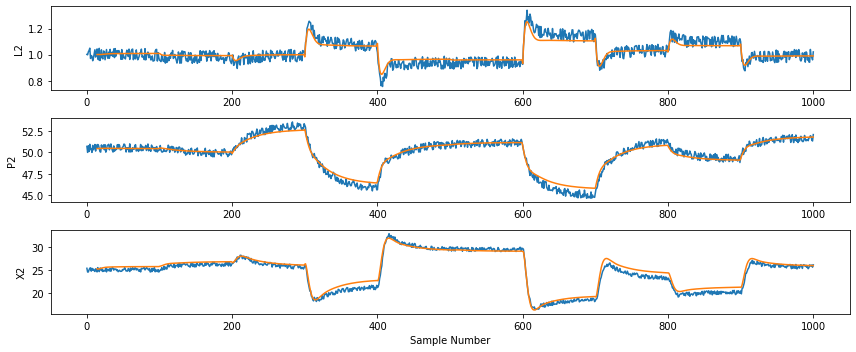

L2 fitness: 79.821%
P2 fitness: 95.326%
X2 fitness: 95.801%
Average:    90.316%
Identification time: 0.27 sec
Simulation time:     0.38 sec
Best Kernel Widths:
[1000.         1000.         1000.            3.16227875 1000.
    3.16227863]
Best mixture weight:
0.7278960778131527


In [7]:
X = np.vstack(X_train)
y = np.vstack(y_train)

# Get the best found hyper-parameters
best_R2, ind = np.max(y), np.argmax(y) 
kw = 10**(X[ind, :-1]*2.5 + 0.5)
w  = X[ind, -1]*0.5 + 0.5

sys.identify(Z_train, UI, YI, kw, w)

x_pred, y_pred, exit_code = sys.simulate(Z_valid)

plt.figure(figsize=(12, 5))
var_name = ('L2', 'P2', 'X2')
for k in range(len(sys.YI)):
    plt.subplot(3, 1, k+1)
    plt.plot(Z_valid[:, sys.YI[k]])
    plt.plot(np.arange(sys.n_lags-1, Z_valid.shape[0]), y_pred[:, k])
    plt.ylabel(var_name[k])
plt.xlabel('Sample Number')
plt.tight_layout()
plt.show()

r2 = sys.R2_score(Z_valid, y_pred)
print(f"L2 fitness: {r2[0]*100:.3f}%")
print(f"P2 fitness: {r2[1]*100:.3f}%")
print(f"X2 fitness: {r2[2]*100:.3f}%")
print(f"Average:    {np.mean(r2)*100:.3f}%")

print(f"Identification time: {sys.ident_time:.2f} sec")
print(f"Simulation time:     {sys.sim_time:.2f} sec")
print("Best Kernel Widths:")
print(kw)
print("Best mixture weight:")
print(w)

In [8]:
with open("evap_mkcva_sys4.pkl", "wb") as file:
    pickle.dump(sys, file)

In [9]:
print(x_pred)

[[ 0.00166668 -0.00197476 -0.00282016  0.01547308]
 [ 0.00153222 -0.00212334 -0.00259335  0.01355124]
 [ 0.00136705 -0.00225995 -0.00259979  0.01201478]
 ...
 [-0.0115043   0.01562688 -0.00853513  0.0182612 ]
 [-0.01150995  0.01568181 -0.00856637  0.01830633]
 [-0.01151542  0.01573496 -0.0085966   0.01835   ]]
